#Homework 6: Model Based RL With Deep Dynamics Models (10 Pts)

All homeworks are self-contained. They can be completed in their respective notebooks. To edit and re-run code, you can therefore simply edit and restart the code cells below. There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window). This file should automatically be synced with your Google Drive. We also save all recordings and logs in it by default so that you won't lose your work in the event of an instance timeout. However, you will need to re-mount your Google Drive and re-install packages with every new instance.

In [ ]:
# Your work will be stored in a folder called `drl_ws22` by default to prevent Colab
# instance timeouts from deleting your edits.
# We do this by mounting your google drive on the virtual machine created in this colab
# session. For this, you will likely need to sign in to your Google account and copy a
# passcode into a field below

import os
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
# Create paths in your google drive
DRIVE_PATH = '/content/gdrive/My\ Drive/drl_ws22'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
    % mkdir $DRIVE_PATH

# the space in `My Drive` causes some issues,
# make a symlink to avoid this
SYM_PATH = '/content/drl_ws22'
if not os.path.exists(SYM_PATH):
    !ln -s $DRIVE_PATH $SYM_PATH
! cd $SYM_PATH

In [ ]:
# Install **python** packages

!pip install matplotlib numpy tqdm torch pybullet
# for open ai gym
!pip install gym==0.17.2

!git clone https://github.com/benelot/pybullet-gym lib/pybullet-gym
!pip install -e lib/pybullet-gym

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1


Restart your runtime once the packages are Installed.

We start by importing some necessary packages and defining helper functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pybulletgym
from gym.wrappers import Monitor

from sklearn.preprocessing import StandardScaler

import torch, os
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from tqdm import tqdm
import datetime
import time

import gym
import numpy as np
import seaborn as sns

# specify the path to save the recordings of this run to.
data_path = '/content/drl_ws22/exercise_6'
data_path = os.path.join(data_path, time.strftime("%d-%m-%Y_%H-%M"))
if not (os.path.exists(data_path)):
    os.makedirs(data_path)


# this function will automatically save your figure into your google drive folder (if correctly mounted!)
def save_figure(save_name: str) -> None:
    assert save_name is not None, "Need to provide a filename to save to"
    plt.savefig(os.path.join(data_path, save_name + ".png"))

#Set Up The Pybullet Inverted Pendulum Environment



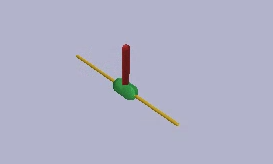

In [ ]:
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
 env = gym.make('InvertedPendulumSwingupPyBulletEnv-v0')

# Model-Based Reinforcement Learning

## Principle
We consider the optimal control problem of an MDP with an **unknown deterministic** reward function $r$ and subject to **unknown deterministic** dynamics $s_{t+1} = f(s_t, a_t)$:

$$\max_{(a_0,a_1,\dotsc)} \sum_{t=0}^\infty \gamma^t r(s_t,a_t)$$

In **model-based reinforcement learning**, this problem is solved in **two steps**:
1. **Model learning**:
We learn a model of the dynamics $f_\theta \simeq f$ and reward function $r_\theta \simeq r$ through regression on interaction data.
2. **Planning**:
We leverage the dynamics model $f_\theta$ to compute the optimal trajectory $$\max_{(a_0,a_1,\dotsc)} \sum_{t=0}^\infty \gamma^t r_{\theta}(\hat{s}_t,a_t)$$ following the learnt dynamics $\hat{s}_{t+1} = f_\theta(\hat{s}_t, a_t)$.

(We can easily extend to stochastic dynamics, but we consider the simpler case in this homework)


In this homework you will implement the model-based algorithm proposed in section IV of [this paper](https://arxiv.org/abs/1708.02596) with some differences: 

1. along with the next environment state, also the reward is learned. To do that another neural network has been used.
2. We train on the pybullet gym environment of inverted pendulum.

$$
\begin{aligned}
&\overline{\text { Algorithm } \mathbf{1} \text { Model-based Reinforcement Learning }} \\
&\hline \text { 1: gather dataset } \mathcal{D}_{\text {RAND }} \text { of random trajectories } \\
&\text { 2: initialize empty dataset } \mathcal{D}_{\text {RL }} \text {, and randomly initialize } f_{\theta} \\
&  \text{ 3: } \textbf{for} \text{ iter=1 to max_iter } \textbf{do}  \\
&\quad  \quad \quad \textbf {Model Learning } \\
&\text { 4:} \quad  \quad \text{ train } f_{\theta}(\mathbf{s}, \mathbf{a}) \text{ and } r_{\theta}(\mathbf{s}, \mathbf{a}) \text { by performing gradient descent on MSE Loss }  \\
& \quad \quad  \quad \text { using } \mathcal{D}_{\text {RAND }} \text { and } \mathcal{D}_{\text {RL }} \\
&\quad  \quad \quad \textbf {Planning and More Experience Collection } \\
&\text { 5: } \quad  \quad  \textbf { for } t=1 \text { to } T \textbf { do } \\
&\text { 6: } \quad \quad \quad \quad \text { get agent's current state } \mathbf{s}_{t} \\
&\text { 7: } \quad \quad \quad \quad \text { use } f_{\theta} \text { and } r_{\theta} \text { to estimate optimal action sequence } \mathbf{A}_{t}^{(H)} \\
&\text { 8: } \quad \quad \quad \quad \text { execute first action } \mathbf{a}_{t} \text { from selected action sequence } \\
&\text { 9: } \quad \quad \quad \quad\text { Add } \{s_t,  s_{t+1}, r_t, a_t\} \text { to } \mathcal{D}_{\text {RL }} \\
&\text { 10: } \quad \text { end for } \\
&\text { 11: end for } \\
&\hline
\end{aligned}
$$

You will notice that compared to model free methods, model based methods are more sample efficient. For this environment expect the algorithm to receive reasonable rewards (greater than 600 in about 15 iterations).

# Collect Random Trajectories To Train A Dynamics Model and Reward Model (Experience Collection)

First, we randomly interact with the environment to produce a batch of experiences 

$$D = \{s_t,  s_{t+1}, r_t, a_t\}_{t\in[1,N]}$$

In [ ]:
def gather_random_trajectories(num_traj, env):
    '''
    Run num_traj random trajectories to gather information about the next state and reward.
    Data used to train the models in a supervised way.
    '''
    dataset_random = []

    game_rewards = []
    with tqdm(total=num_traj, position=0, leave=True) as pbar:
        for n in tqdm(range(num_traj),position=0, leave=True):
            #env.render()
            obs = env.reset()
            while True:
                sampled_action = env.action_space.sample()
                new_obs, reward, done, _ = env.step(sampled_action)


                dataset_random.append([obs, new_obs, reward, sampled_action])

                obs = new_obs
                game_rewards.append(reward)

                if done:
                    break
            pbar.update()

    # print some stats
    print('Mean R:', np.round(np.sum(game_rewards) / num_traj, 2), 'Max R:', np.round(np.max(game_rewards), 2),
          np.round(len(game_rewards) / num_traj))

    return dataset_random


# Deep Dynamics Models With Feed Forward Neural Network

A dynamics model takes in the state ($s_t$) and action($a_t$) at the current time step and predicts the state ($s_{t+1}$) at the next time step.  

**However this function can be difficult to learn when the states $s_t$ and $s_{t+1}$ are too similar and the action has seemingly littl eeffect on the output; this difficulty becomes more pronouncedas the time between states $\Delta t$ becomes smaller and the state differences do not indicate the underlying dynamics well. Thus we typically a function that predict the differences to the next state. i.e. $\Delta s_{t+1} = s_{t+1} - s_t = f(s_t,a_t)$. This allows us to learn more accurate models in practice.**

In the following block, we define the Dynamics Model Class. Each instance of this class is a Neural Dynamics Model that computes the dynamics function $\Delta s_{t+1} = f_{\Theta}(s_t, a_t)$. The input of this Network is a state and action at current time step $s_t$, $a_t$ respectively and the output the differences to the next state at the next time step. Please note that for NN training, we normally feed data in a mini-batch manner. Since each state in current task is a 1st order image tensor (concatenation of $s_t$ and $a_t$), the Dynamics model expects input to be a 2nd order tensor with shape (mini-batch, state_dim + action_dim). And the output is a 2nd order tensor with shape (mini-batch, state_dim).

In [ ]:
###########################Create A Neural Network Dynmics Model####################################
class NNDynamicModel(nn.Module):
    '''
    Model that predict the differnce to next state, given the current state and action
    '''
    def __init__(self, input_dim, obs_output_dim):
      '''
      input_dim: state_dim + action_dim
      output_dim: state_dim
      '''
      super(NNDynamicModel, self).__init__()

      self.mlp = nn.Sequential(
          nn.Linear(input_dim, 512),
          nn.BatchNorm1d(num_features=512),
          nn.ReLU(),
          nn.Linear(512,256),
          nn.BatchNorm1d(num_features=256),
          nn.ReLU(),
          nn.Linear(256, obs_output_dim)
      )

    def forward(self, x):
        return self.mlp(x.float())

# Deep Reward Models With Feed Forward Neural Network

A reward model takes in the state ($s_t$) and action($a_t$) at the current time step and predicts reward ($r_{t}$) that we can obtain based on that action.  

In the following block, we define the Reward Model Class. Each instance of this class is a Neural Reward Model that computes the reward function $r_{t} = r_{\theta}(s_t, a_t)$. The input of this Network is a state and action at current time step $s_t$, $a_t$ respectively and the output the rewards at the next time step. Please note that for NN training, we normally feed data in a mini-batch manner. Since each state in current task is a 1st order image tensor (concatenation of $s_t$ and $a_t$), the Dynamics model expects input to be a 2nd order tensor with shape (mini-batch, state_dim + action_dim). And the output is a 2nd order tensor with shape (mini-batch, reward_dim).

In [ ]:
class NNRewardModel(nn.Module):
    '''
    Model that predict the reward given the current state and action
    '''
    def __init__(self, input_dim, reward_output_dim):
        '''
        input_dim: state_dim + action_dim
        output_dim: reward_dim
        '''
        super(NNRewardModel, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(256, reward_output_dim)
        )

    def forward(self, x):
        return self.mlp(x.float())

# Training The Dynamics And Reward Models


We can now train our models $f_\theta$ and $r_\theta$ in a supervised fashion to minimize an MSE loss over our experience batch by stochastic gradient descent:

$$L_{Dynamics} = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||\Delta s_{t+1}- f_\theta(s_t, a_t)||^2$$

$$L_{Reward} = \frac{1}{|D|}\sum_{s_t,a_t,r_{t}\in D}||r_{t}- r_\theta(s_t, a_t)||^2$$

-----
In practice, it’s helpful to normalize the target of a neural network.  So in the code, we’ll train the network to predict a normalized version of the change in state, as in

$$L_{Dynamics} = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||\text{normalize}(\Delta s_{t+1})- f_\theta(s_t, a_t)||^2$$

Similarly, we’ll train the network to predict a normalized version of the reward, as in

$$L_{Reward} = \frac{1}{|D|}\sum_{s_t,a_t,r_{t}\in D}||\text{normalize}(r_{t})- r_\theta(s_t, a_t)||^2$$



------
Since $f_{\theta}$ is trained to predict the normalized state difference, you generate thenext prediction with
$$
\hat{\mathbf{s}}_{t+1}=\mathbf{s}_{t}+\text { Unnormalize }\left(f_{\theta}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)\right)
$$ \\

You generate the reward with $$
\hat{\mathbf{r}}_{t}=\text { Unnormalize }\left(r_{\theta}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)\right)
$$

## Task 1: Training the Dynamics and Reward Models (3 Pts)
We will use the means squarred error (MSE) loss as shown in the equations above:
- implement the MSE loss in the *model_MSEloss* function

To train the dynamics and reward models, we have to properly prepare the training data. Implement the following steps in the *train_dyna_model*
- split the dataset into training (80%) and testing (20%) data
- randomly shuffle the training data (hint: you can use *np.random.shuffle* for this)
- create the input and output data for the dynamics and reward model. Think what the inputs for each of these networks are. You can see them in the equations above. Do this procedure for both, the testing and the validation data set.


** The places you have to fill in your code are marked **

**Note** We use sklearn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to perform normalization and unnormalization steps, through out this assignment.

In [ ]:
def model_MSEloss(y_truth, y_pred, device):
    '''
    input_1: ground truth values (batch_size x data_dimension)
    input_2: predicted values (batch_size x data_dimension)
    input_3: device specification for pytorch ('cuda' / 'cpu)

    return: mean squared error loss between

    Compute the MSE (Mean Squared Error) between y_truth and y_pred
    '''

    ### Your code starts here ###
    return 0
    ### Your code ends here ###
    

In [ ]:
def train_dyna_model(random_dataset, rl_dataset, env_model, rew_model, batch_size, max_model_iter, num_examples_added, ENV_LEARNING_RATE, REW_LEARNING_RATE, device):
    '''
    Train the two models that predict the next state and the expected reward
    '''
    print("................Training Dynamics and Reward Models With Collected Data So Far.....................")

    env_optimizer = optim.Adam(env_model.parameters(), lr=ENV_LEARNING_RATE)
    rew_optimizer = optim.Adam(rew_model.parameters(), lr=REW_LEARNING_RATE)

    ###Accessing Inputs and Outputs to the Neural Network From Data Buffer D###
    if len(rl_dataset) > 0:
        # Concatenate the random dataset with the RL dataset. Used only in the aggregation iterations
        d_concat = np.concatenate([random_dataset, rl_dataset], axis=0)
    else:
        d_concat = np.array(random_dataset)


    ### >>>>>>>>>Your code starts here<<<<<<<<< ###

    # TODO: Split the dataset into train(80%) and test(20%)
    #D_train =
    #D_valid =

    print("len(D):", len(d_concat), 'len(Dtrain)', len(D_train))

    # TODO: Shuffle the dataset
    #D_train =


    # TODO: Create the input and output for the train dynamics and reward models by accessing D_train and D_test
    #X_train =
    #y_rew_train =
    #y_next_state_train =
    #y_diff_train =

    # Create the input and output array for the validation
    #X_valid =
    #y_rew_valid =
    #y_next_state_valid =
    #y_diff_valid =

    ###>>>>>>>>>>>> Your code Ends here<<<<<<<<<< ###

    ####Standardize The Inputs And Outputs ###

    # Standardize the input features by removing the mean and scaling to unit variance
    input_scaler = StandardScaler()
    X_train = input_scaler.fit_transform(X_train)
    X_valid = input_scaler.transform(X_valid)

    # Standardize the outputs by removing the mean and scaling to unit variance

    env_output_scaler = StandardScaler()
    y_diff_train = env_output_scaler.fit_transform(y_diff_train)
    y_diff_valid = env_output_scaler.transform(y_diff_valid)

    rew_output_scaler = StandardScaler()
    y_rew_train = rew_output_scaler.fit_transform(y_rew_train)
    y_rew_valid = rew_output_scaler.transform(y_rew_valid)

    # store all the scalers in a variable to later uses
    standardizers = (input_scaler, env_output_scaler, rew_output_scaler)

    losses_env = []
    losses_rew = []

    # go through max_model_iter supervised iterations
    with tqdm(total=max_model_iter, position=0, leave=True) as pbar:
      for it in tqdm(range(max_model_iter),position=0, leave=True):
          # create mini batches of size batch_size
          for mb in range(0, len(X_train), batch_size):

              if len(X_train) > mb+BATCH_SIZE:
                  X_mb = X_train[mb:mb+BATCH_SIZE]

                  y_diff_mb = y_diff_train[mb:mb+BATCH_SIZE]
                  y_rew_mb = y_rew_train[mb:mb+BATCH_SIZE]

                  # Add gaussian noise with mean 0 and variance 0.0001 as in the paper
                  X_mb += np.random.normal(loc=0, scale=0.001, size=X_mb.shape)

                  ## Optimization of the 'env_model' neural net

                  env_optimizer.zero_grad()
                  # forward pass of the model to compute the output
                  pred_state = env_model(torch.tensor(X_mb).to(device))
                  # compute the MSE loss
                  loss = model_MSEloss(y_diff_mb, pred_state, device)

                  if it == (max_model_iter - 1):
                      losses_env.append(loss.cpu().detach().numpy())

                  # backward pass
                  loss.backward()
                  # optimization step
                  env_optimizer.step()


                  ## Optimization of the 'rew_model' neural net
                  rew_optimizer.zero_grad()
                  # forward pass of the model to compute the output
                  pred_rew = rew_model(torch.tensor(X_mb).to(device))
                  # compute the MSE loss
                  loss = model_MSEloss(y_rew_mb, pred_rew, device)

                  if it == (max_model_iter - 1):
                      losses_rew.append(loss.cpu().detach().numpy())
                  # backward pass
                  loss.backward()
                  # optimization step
                  rew_optimizer.step()

      # Evalute the models every 10 iterations and print the losses
      if it % 10 == 0:
          env_model.eval()
          rew_model.eval()

          pred_state = env_model(torch.tensor(X_valid).to(device))
          pred_rew = rew_model(torch.tensor(X_valid).to(device))
          env_model.train(True)
          rew_model.train(True)

          valid_env_loss = model_MSEloss(y_diff_valid, pred_state, device)
          valid_rew_loss = model_MSEloss(y_rew_valid, pred_rew, device)

          print('..', it, valid_env_loss.cpu().detach().numpy(), valid_rew_loss.cpu().detach().numpy())


    ## Evaluate the MSE losses

    env_model.eval()
    rew_model.eval()

    pred_state = env_model(torch.tensor(X_valid).to(device))
    pred_rew = rew_model(torch.tensor(X_valid).to(device))
    env_model.train(True)
    rew_model.train(True)

    valid_env_loss = model_MSEloss(y_diff_valid, pred_state, device)
    valid_rew_loss = model_MSEloss(y_rew_valid, pred_rew, device)

    return np.mean(losses_env), np.mean(losses_rew), valid_env_loss.cpu().detach().numpy(), valid_rew_loss.cpu().detach().numpy(), standardizers


# Planning With Dynamics And Reward Models

Given the learned dynamics and reward models, we now want to select and execute actions that minimize a cost function (long term rewards). Ideally, you would calculate these actions by solving the following optimization:

$$
\mathbf{a}_{t}^{*}=\arg \max _{\mathbf{a}_{t: \infty}} \sum_{t^{\prime}=t}^{\infty} r_{\theta}\left(\hat{\mathbf{s}}_{t^{\prime}}, \mathbf{a}_{t^{\prime}}\right) \text { where } \hat{\mathbf{s}}_{t^{\prime}+1}=\hat{\mathbf{s}}_{t^{\prime}}+f_{\theta}\left(\hat{\mathbf{s}}_{t^{\prime}}, \mathbf{a}_{t^{\prime}}\right)
$$

However, solving the above equation is impractical for two reasons:
- planning over an infinite sequence of actions is impossible and
- the learned dynamics model is imperfect, so using it to plan in such an open-loop manner will lead to accumulating errors over time and planning far into the future will become very inaccurate.

Instead, we will solve the following gradient-free optimization problem:
$$
\mathbf{A}^{*}=\arg \max _{\left\{\mathbf{A}^{(0)}, \ldots, \mathbf{A}^{(K-1)}\right\}} \sum_{t^{\prime}=t}^{t+H-1} r_{\theta}\left(\hat{\mathbf{s}}_{t^{\prime}}, \mathbf{a}_{t^{\prime}}\right) \text { s.t. } \hat{\mathbf{s}}_{t^{\prime}+1}=\hat{\mathbf{s}}_{t^{\prime}}+f_{\theta}\left(\hat{\mathbf{s}}_{t^{\prime}}, \mathbf{a}_{t^{\prime}}\right)
$$
in which $\mathbf{A}^{(k)}=\left(a_{t}^{(k)}, \ldots, a_{t+H-1}^{(k)}\right)$ are each a random action sequence of length $H$. 


## Planner 1: Random Shooting Based Planner

We will now use a simple random shooting method to solve the following gradient-free optimization problem :
$$
\mathbf{A}^{*}=\arg \min _{\left\{\mathbf{A}^{(0)}, \ldots, \mathbf{A}^{(K-1)}\right\}} \sum_{t^{\prime}=t}^{t+H-1} r_{\theta}\left(\hat{\mathbf{s}}_{t^{\prime}}, \mathbf{a}_{t^{\prime}}\right) \text { s.t. } \hat{\mathbf{s}}_{t^{\prime}+1}=\hat{\mathbf{s}}_{t^{\prime}}+f_{\theta}\left(\hat{\mathbf{s}}_{t^{\prime}}, \mathbf{a}_{t^{\prime}}\right)
$$
in which $\mathbf{A}^{(k)}=\left(a_{t}^{(k)}, \ldots, a_{t+H-1}^{(k)}\right)$ are each a random action sequence of length $H$.

**Random Shooting**: The simplest gradient-free optimizer simply generates $N$ independent random action sequences $\left\{A_{0} \ldots A_{N}\right\}$, where each sequence $A_{i}=\left\{a_{t}^{i} \ldots a_{t+H-1}^{i}\right\}$ is of length $H$ action. Given a reward function $r(s, a)$ that defines the task, and given future state predictions $\hat{s}_{t+1}=f_{\theta}\left(\hat{s}_{t}, a_{t}\right)+\hat{s}_{t}$ from the learned dynamics model $f_{\theta}$, the optimal action sequence $A_{i^{*}}$ is selected to be the one corresponding to the sequence with highest predicted return: $i^{*}=\arg \max _{i} \sum_{t^{\prime}=t}^{t+H-1} r\left(\hat{s}_{t^{\prime}}, a_{t^{\prime}}^{i}\right) .$

In [ ]:
def random_shooting_based_control(env_model, rew_model, real_obs, num_sequences, horizon_length, sample_action, standardizers, device):
    '''
    Use a random-sampling shooting method, generating random action sequences. The first action with the highest reward of the entire sequence is returned.
    env_model: the Neural Network model of the environment
    rew_model: the Neural Network model of the environment
    real_obs: the observations last seen from the real physical environment
    num_sequences: number of sequences to generate
    horizon_length: the planning horizon H
    sample_action: the function which is used to sample the action. We usually use the env.action_space.sample function.
    standardizers: a tuple containing the standardizers which were created during training the models. Needed to unnormalize.
    device: device specification for pytorch ('cuda' / 'cpu)
    '''
    input_scaler, env_output_scaler, rew_output_scaler = standardizers

    m_obs = np.array([real_obs for _ in range(num_sequences)])

    # array that contains the cumilative rewards for all the sequence
    cumilative_rewards = np.zeros((num_sequences, 1))
    first_sampled_actions = []

    env_model.eval()
    rew_model.eval()

    ## Create a batch of size 'num_sequences' (number of trajectories) to roll the models 'horizon_length' times.
    ## i.e. roll a given number of trajectories in a single batch (to increase speed)

    # sampled actions for each sequence
    sampled_action_sequences = []
    for _ in range(num_sequences):
      sampled_action_sequence = [sample_action() for _ in range(horizon_length)]
      sampled_action_sequences.append(sampled_action_sequence)

    sampled_action_sequences = np.array(sampled_action_sequences)


    for t in range(horizon_length):
      # select action for time step t for each sequence
      sampled_actions = sampled_action_sequences[:,t,:]
      # scale the input
      models_input = input_scaler.transform(np.concatenate([m_obs, sampled_actions], axis=1))
      # compute the next state for each sequence
      pred_obs = env_model(torch.tensor(models_input).to(device))
      # and the reward
      pred_rew = rew_model(torch.tensor(models_input).to(device))

      # inverse scaler transofrmation
      pred_obs = env_output_scaler.inverse_transform(pred_obs.cpu().detach().numpy())
      # and add previous observation
      m_obs = pred_obs + m_obs

      assert(pred_rew.cpu().detach().numpy().shape == cumilative_rewards.shape)

      # sum of the expected rewards
      cumilative_rewards += pred_rew.cpu().detach().numpy()

      if t == 0:
        first_sampled_actions = sampled_actions

    env_model.train(True)
    rew_model.train(True)

    # Best the position of the sequence with the higher reward
    arg_best_reward = np.argmax(cumilative_rewards)
    best_sum_reward = cumilative_rewards[arg_best_reward].squeeze()
    # take the first action of this sequence
    best_action = first_sampled_actions[arg_best_reward]

    return best_action, best_sum_reward

# Cross Entropy Method (CEM) for Planning (5 Pts)
The random shooting approach has been shown to achieve success on continuous control tasks with learned models, but it has numerous drawbacks: it scales poorly with the dimension of both the planning horizon and the action space, and it often is insufficient for achieving high task performance since a sequence of actions sampled at random often does not directly lead to meaningful behavior. Therefor, the Cross Entropy Method is a favorable planning approach in model based reinforcement learning.

We already got known to CEM in the stochastic search homework. However, here, we consider a different application.

We will use CEM to solve the following gradient-free optimization problem :
$$
\mathbf{A}^{*}=\arg \min _{\left\{\mathbf{A}^{(0)}, \ldots, \mathbf{A}^{(K-1)}\right\}} \sum_{t^{\prime}=t}^{t+H-1} r_{\theta}\left(\hat{\mathbf{s}}_{t^{\prime}}, \mathbf{a}_{t^{\prime}}\right) \text { s.t. } \hat{\mathbf{s}}_{t^{\prime}+1}=\hat{\mathbf{s}}_{t^{\prime}}+f_{\theta}\left(\hat{\mathbf{s}}_{t^{\prime}}, \mathbf{a}_{t^{\prime}}\right)
$$
in which $\mathbf{A}^{(k)}=\left(a_{t}^{(k)}, \ldots, a_{t+H-1}^{(k)}\right)$ are each a random action sequence of length $H$

**Cross-Entropy Method** (`CEM`) is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

The Cross-entropy method (CEM) approach, begins as the random shooting approach, but then does this sampling for multiple iterations $m \in\{0 \ldots M\}$ at each time step. The top $J$ highest-scoring action sequences from each iteration are used to update and refine the mean and variance of the sampling distribution for the next iteration, as follows:

\begin{aligned}
A_{i} &=\left\{a_{0}^{i} \ldots a_{H-1}^{i}\right\} \text {, where } a_{t}^{i} \sim \mathcal{N}\left(\mu_{t}^{m}, \Sigma_{t}^{m}\right) \forall i \in N, t \in 0 \ldots H-1 \\
A_{\text {elites }} &=\operatorname{sort}\left(A_{i}\right)[-J:] \\
\mu_{t}^{m+1} &=  \operatorname{mean}\left(A_{\text {elites }}\right) \quad \forall t \in 0 \ldots H-1 \\
\Sigma_{t}^{m+1} &= \operatorname{var}\left(A_{\text {elites }}\right)\quad  \forall t \in 0 \ldots H-1
\end{aligned}

After $M$ iterations, the optimal actions are selected to be the resulting mean of the action distribution.
Note that, since our model is imperfect and things will never go perfectly according to plan, we adopt a model predictive control (MPC) approach.
The MPC planner replans at every time step similar to previous section with random shooting planner. Students may refer to [this paper](/https://arxiv.org/pdf/1909.11652.pdf).

## Task 2: Implementing the CEM for Planning
In the following task you will implement the CEM following the standard procedure. In each optimization iteration, your code will execute the steps mentioned before, which we detail in the following.
For each optimization step, do:
- sample a sequence of actions $A_{i}$ from the Gaussian distribution from the iteration before
- prepare the data for inputting to the dynamics and rewards model by standardizing it
- perform the inference of the reward model to obtain a reward prediction
- perform the inference via the dynamics model to obtain the observation difference prediction
- unnormalize the predicted observation difference
- obtain the observation of the next step by adding the predicted observation to the current observation
- sum the predicted reward to the rewards from the steps before

After each optimization step, do:
- obtain the top 10 action sequences $A_{i}$  which lead to the highes cumulative reward
- update the search distribution by calculating the sample mean and the sample standard deviation using the elite samples
**NOTE:** In the last homework, we have calculate the full covariance of the distribution. Here we only consider the standard deviation of each dimension of the search space.

We have provided you with comments guiding you through the parts you need to implement.

In [ ]:
def cem_based_control(env_model, rew_model, real_obs, num_sequences, horizon_length, sample_action, standardizers, device):
    '''
    Use a cem method for planning
    env_model: the Neural Network model of the environment
    rew_model: the Neural Network model of the environment
    real_obs: the observations last seen from the real physical environment
    num_sequences: number of sequences to generate
    horizon_length: the planning horizon H
    sample_action: the function which is used to sample the action. We usually use the env.action_space.sample function.
    standardizers: a tuple containing the standardizers which were created during training the models. Needed to unnormalize.
    device: device specification for pytorch ('cuda' / 'cpu)
    '''
    optimisation_iters = 3

    input_scaler, env_output_scaler, rew_output_scaler = standardizers

    first_sampled_actions = []

    env_model.eval()
    rew_model.eval()

    ## Create a batch of size 'num_sequences' (number of trajectories) to roll the models 'horizon_length' times.
    ## i.e. roll a given number of trajectories in a single batch (to increase speed)

    # sampled actions for each sequence each sequence is of length H.
    sampled_action_sequences = []
    for _ in range(num_sequences):
        sampled_action_sequence = [sample_action() for _ in range(horizon_length)]
        sampled_action_sequences.append(sampled_action_sequence)

    sampled_action_sequences = np.array(sampled_action_sequences)
    action_dim = sampled_action_sequences.shape[-1]
    ### >>>>>>>>>Your code starts here<<<<<<<<< ###

    action_mean, action_std_dev =  # TODO: Calculate the mean and standard deviation of the sampled action sequences

    for _ in range(optimisation_iters):
        '''
        In this section you implement an MPC with CEM method.  In each optimization iteration,
        you sample actions sequences from a normal distribution, Calculate the cost for each
        sequence using the learnt dyanmics and reward models. We will use a MPC similar to previous
        section to replan at every timestep.
        '''
        sampled_action_sequences =  # TODO: Sample from a Gaussian Using The Means and Standard Deviations
        # array that contains the cumilative_rewards for all the sequence, set to zero intially before an optimization iteration
        cumilative_rewards = np.zeros((num_sequences, 1))
        m_obs = np.array([real_obs for _ in range(num_sequences)])

        for t in range(horizon_length):
            # sampled actions for each sequence
            sampled_actions = sampled_action_sequences[:, t, :]
            # scale the input
            models_input = input_scaler.transform(np.concatenate([m_obs, sampled_actions], axis=1))

            
            pred_obs = # TODO compute the differences to the next state using the dynamics model
            
            pred_rew = # TODO compute the reward using the reward model
            
            pred_obs_unnormlized = # TODO inverse scaler transofrmation (Unnormalize the predicted differences)
            
            m_obs = # TODO and add pred_unnormalized_observation to the previous observation

            assert (pred_rew.cpu().detach().numpy().shape == cumilative_rewards.shape)

            # sum of the expected rewards
            cumilative_rewards #TODO #keep on adding the rewards obtained so far

            if t == 0:
                first_sampled_actions = sampled_actions
            
        # TODO Select Top K Action Sequences (lets call them elite_sequences) that gave the highest cumilative reward


        #TODO: Recalculate the mean and variances using the elite (topk) action sequences

    ### >>>>>>>>>Your code ends here<<<<<<<<< ###
    env_model.train(True)
    rew_model.train(True)

    # Best the position of the sequence with the higher reward
    arg_best_reward = np.argmax(cumilative_rewards)
    best_sum_reward = cumilative_rewards[arg_best_reward].squeeze()
    # take the first action of this sequence
    best_action = first_sampled_actions[arg_best_reward] #you can also choose the best action as the mean of the elites from last optimization iteration. 
                                                          # However we do a greedy step in the end where the best among the elites from last iteration is chosen.

    return best_action, best_sum_reward


# Task 3: What is a Model Predictive Controller (MPC)? (2 Pts)

Since our dynamics and reward models can be imperfect and things will never go perfectly ac-ording to plan, we adopt a model predictive control (MPC) approach. Explain in few lines whats the basic priniciple behind an MPC.


# Main Loop

Under Default Hyperparameters, Run the Main MBRL Loop with two planners Random Shooting and CEM. You will compare the reward plots with both the planners.

\begin{aligned}
&\overline{\text { Algorithm } \mathbf{1} \text { Model-based Reinforcement Learning }} \\
&\hline \text { 1: gather dataset } \mathcal{D}_{\text {RAND }} \text { of random trajectories } \\
&\text { 2: initialize empty dataset } \mathcal{D}_{\text {RL }} \text {, and randomly initialize } f_{\theta} \\
&  \text{ 3: } \textbf{for} \text{ iter=1 to max_iter } \textbf{do}  \\
&\quad  \quad \quad \textbf {Model Learning } \\
&\text { 4:} \quad  \quad \text{ train } f_{\theta}(\mathbf{s}, \mathbf{a}) \text{ and } r_{\theta}(\mathbf{s}, \mathbf{a}) \text { by performing gradient descent on MSE Loss }  \\
& \quad \quad  \quad \text { using } \mathcal{D}_{\text {RAND }} \text { and } \mathcal{D}_{\text {RL }} \\
&\quad  \quad \quad \textbf {Planning and More Experience Collection } \\
&\text { 5: } \quad  \quad  \textbf { for } t=1 \text { to } T \textbf { do } \\
&\text { 6: } \quad \quad \quad \quad \text { get agent's current state } \mathbf{s}_{t} \\
&\text { 7: } \quad \quad \quad \quad \text { use } f_{\theta} \text { and } r_{\theta} \text { to estimate optimal action sequence } \mathbf{A}_{t}^{(H)} \\
&\text { 8: } \quad \quad \quad \quad \text { execute first action } \mathbf{a}_{t} \text { from selected action sequence } \\
&\text { 9: } \quad \quad \quad \quad\text { Add } \{s_t,  s_{t+1}, r_t, a_t\} \text { to } \mathcal{D}_{\text {RL }} \\
&\text { 10: } \quad \text { end for } \\
&\text { 11: end for } \\
&\hline
\end{aligned}

**Students should get two reward plots, one with the random shooting based planner (set planner = 'random_shooting') and another one with CEM planner (set planner = 'cem'). Expect equal or greater than 500 reward for both cases in 20 iterations. Please submit the saved figures for both planners with the default parameters given here.**

In [ ]:
# 'cuda' or 'cpu'
device = 'cuda'
planner = 'cem' #Set this to 'cem' if you want use CEM Planner

In [ ]:
# Main loop hyper
# Do Not Change This Block
# Do not change This Block

AGGR_ITER = 20 #Number Of Outer iterations 
STEPS_PER_AGGR = 500 #Minimum Number of steps of experiences to add to buffer in each iteration

# Number of Randon Trajectories (Experiences) To Collect for $D_{random}$
NUM_RAND_TRAJECTORIES = 100


# Supervised Model Hyperp
ENV_LEARNING_RATE = 1e-3
REW_LEARNING_RATE = 1e-3
BATCH_SIZE = 2000
TRAIN_ITER_MODEL = 55

# Controller Hyperp
HORIZION_LENGTH = 15
NUM_ACTIONS_SEQUENCES = 200

save_video_test = True

now = datetime.datetime.now()
date_time = "{}_{}.{}.{}".format(now.day, now.hour, now.minute, now.second)
env = gym.make('InvertedPendulumSwingupPyBulletEnv-v0')
obs = env.reset()

#Step 1:  gather the dataset of random sequences
print(">>>>>>>>>>>>>>Gathering Random Trajectories to train Dynamics and Reward Models")
rand_dataset = gather_random_trajectories(NUM_RAND_TRAJECTORIES, env)

rl_dataset = []
mean_rew_list = []

#Step 2: Initialize the models and itarate over model learning , planning and on policy experience collection
env_model = NNDynamicModel(env.action_space.shape[0] + env.observation_space.shape[0],
                          env.observation_space.shape[0]).to(device)
rew_model = NNRewardModel(env.action_space.shape[0] + env.observation_space.shape[0], 1).to(device)

game_reward = 0
num_examples_added = len(rand_dataset)

for n_iter in range(AGGR_ITER):

  # supervised training of the dataset (random and rl if it exists)
  train_env_loss, train_rew_loss, valid_env_loss, valid_rew_loss, standardizers = train_dyna_model(rand_dataset,
                                                                                          rl_dataset,
                                                                                          env_model,
                                                                                          rew_model,
                                                                                          BATCH_SIZE,
                                                                                          TRAIN_ITER_MODEL,
                                                                                          num_examples_added,
                                                                                          ENV_LEARNING_RATE,
                                                                                          REW_LEARNING_RATE,
                                                                                          device)
  print('{} >> Eloss:{:.4f} EV loss:{:.4f} -- Rloss:{:.4f} RV loss:{:.4f}'.format(n_iter, train_env_loss,
                                                                                  valid_env_loss,
                                                                                  train_rew_loss,
                                                                                  valid_rew_loss))
  env = wrap_env(gym.make('InvertedPendulumSwingupPyBulletEnv-v0'))
  obs = env.reset()

  num_examples_added = 0
  game_reward = 0
  game_pred_rews = []
  rews = []

  while num_examples_added < STEPS_PER_AGGR:
      while True:
          tt = time.time()
          # Execute the control to roll the sequences and pick the first action of the sequence with the higher reward
          if planner == 'random_shooting':
              action, pred_rew = random_shooting_based_control(env_model, rew_model, obs, NUM_ACTIONS_SEQUENCES,
                                                    HORIZION_LENGTH, env.action_space.sample, standardizers, device)
          elif planner == 'cem':
              action, pred_rew = cem_based_control(env_model, rew_model, obs, NUM_ACTIONS_SEQUENCES,
                                                    HORIZION_LENGTH, env.action_space.sample, standardizers, device)
          else:
              raise ValueError("planner must be random_shooting/cem")
          game_pred_rews.append(pred_rew)

          # one step in the environment with the action returned by the controller
          new_obs, reward, done, _ = env.step(action)

          input_scaler, env_output_scaler, rew_output_scaler = standardizers

          ## Compute the reward and print some stats
          models_input = input_scaler.transform([np.concatenate([obs, action])])
          rew_model.eval()
          p_rew = rew_model(torch.tensor(models_input).to(device))
          rew_model.train(True)
          unnorm_rew = rew_output_scaler.inverse_transform(p_rew.cpu().detach().numpy())
          if num_examples_added == 0:
              print('Steps taken with MPC Planner:', num_examples_added + 1, end='->')
          elif num_examples_added % 25 == 0:
              print(num_examples_added + 1, end='->')
          rl_dataset.append([obs, new_obs, reward, action])

          num_examples_added += 1
          obs = new_obs
          game_reward += reward

          # if the environment is done, reset it and print some stats
          if done:
              print(num_examples_added + 1, end='->')
              obs = env.reset()
              
              rews.append(game_reward)
              game_reward = 0
              game_pred_rews = []
              break

  print('#########################Total Episodic Reward Obtained With Current Policy At Iteration',n_iter,' = ', rews)
  mean_rew_list.append(rews)
  env.close()
  show_video()

## Plot the Reward Curves
fig, ax = plt.subplots(1, figsize=(10,6))
sns.set_style("darkgrid")
idxs = range(len(mean_rew_list))
plt.plot(idxs, mean_rew_list)
if planner == "random_shooting":
    plt.title('Random Shooting')
else:
    plt.title('CEM Control')
plt.ylabel('Rewards')
plt.xlabel('Iterations')
save_figure('Deep_Dynamics_Reward_'+planner)
plt.show()